Here, we want to use the pretrained VGG model to output features to later use as the input to an SVM model.

We use the pretrained VGG-19 available on Pytorch. We also perform the support vector machine training in this notebook.

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, svm, metrics
import os
import glob
import tqdm
import pywt

import torch
import torchvision
from torchvision import datasets
from torchvision import transforms

from scipy import signal
from sklearn.decomposition import PCA

import cv2
import seaborn as sn

In [3]:
# load in data
train_path = "../../project-data/train_another/"
val_path = "../../project-data/validation_another/"
test_path = "../../project-data/test_another/"
img_size = 128
nchannels = 3

npz_file_listing_train = list(glob.glob(os.path.join(train_path, '**/*.npz')))
npz_file_listing_val = list(glob.glob(os.path.join(val_path, '**/*.npz')))
N_train = len(npz_file_listing_train)
N_val = len(npz_file_listing_val)

training_data_X = np.zeros((N_train, img_size, img_size, nchannels))
training_data_y = np.zeros(N_train)
val_data_X = np.zeros((N_val, img_size, img_size, nchannels))
val_data_y = np.zeros(N_val)

it = 0
for npz_file in tqdm.tqdm(npz_file_listing_train):
    training_data_X[it, :, :, :] = np.load(npz_file)['pixels']
    if "no_" in npz_file:
        training_data_y[it] = 0
    else:
        training_data_y[it] = 1
    it += 1
    
it = 0
for npz_file in tqdm.tqdm(npz_file_listing_val):
    val_data_X[it, :, :, :] = np.load(npz_file)['pixels']
    if "no_" in npz_file:
        val_data_y[it] = 0
    else:
        val_data_y[it] = 1
    it += 1

rand_idx = np.random.randint(0, N_train, size=2000)
train_X_sample = training_data_X[rand_idx, :]
train_y_sample = training_data_y[rand_idx]
N_train = 2000

rand_val_idx = np.random.randint(0, N_val, size=1000)
val_X_sample = val_data_X[rand_val_idx, :]
val_y_sample = val_data_y[rand_val_idx]
N_val = 1000

100%|██████████| 2000/2000 [00:11<00:00, 168.94it/s]


Notes on the VGG-19 model:
- Divided into features and classifier
- We want to use the features and maybe the first layers of the classifier
- The input size is: N_train x 3 x 224 x 224
- The output size is: N_train x 4096 (or depends on how many classifier layers we remove)

References:
https://pytorch.org/hub/pytorch_vision_vgg/, 

In [4]:
# look at the vgg19 model overview
model = torchvision.models.vgg19(pretrained=True)
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

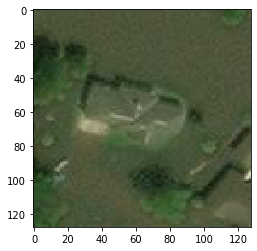

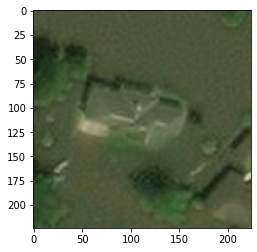

(1, 3, 224, 224)


In [5]:
input_size = 224
resize_im = cv2.resize(src=train_X_sample[0,:,:,:], dsize=(224, 224))

plt.imshow(train_X_sample[0,:,:,:]/255)
plt.show()
plt.imshow(resize_im/255)
plt.show()

final_im = np.zeros((1, 3, 224, 224))
final_im[0, :,:,:] = resize_im.T

print(final_im.shape)

In [6]:
# resize all input images
X_train_resize = np.zeros((N_train, nchannels, input_size, input_size))
X_val_resize = np.zeros((N_val, nchannels, input_size, input_size))
for i in tqdm.tqdm(range(N_train)):
    X_train_resize[i,:,:,:] = cv2.resize(src=train_X_sample[i,:,:,:], dsize=(224, 224)).T
    
for i in tqdm.tqdm(range(N_val)):
    X_val_resize[i,:,:,:] = cv2.resize(src=val_X_sample[i,:,:,:], dsize=(224, 224)).T

100%|██████████| 1000/1000 [00:06<00:00, 163.23it/s]


In [10]:
# load pretrained model
# get rid of last few layers o
model = torchvision.models.vgg19(pretrained=True)
new_classifier = torch.nn.Sequential(*list(model.classifier.children())[:-3])
model.classifier = new_classifier

# dataset loaders
train_set_loader = torch.utils.data.DataLoader(X_train_resize, batch_size=N_train)
val_set_loader = torch.utils.data.DataLoader(X_val_resize, batch_size=N_train)
train_inputs = next(iter(train_set_loader))
val_inputs = next(iter(val_set_loader))

In [11]:
# pass raw data through the pretrained model to get out training features
out_size = 4096
lil_batch_size = 100
num_iter = int(N_train/lil_batch_size)
train_features = np.zeros((N_train, out_size))

for i in tqdm.tqdm(range(num_iter)):
    this_input = train_inputs[i*lil_batch_size:i*lil_batch_size+lil_batch_size,:,:,:]
    out = model(this_input.float())
    train_features[i*lil_batch_size:i*lil_batch_size+lil_batch_size,:] = out.data.numpy()

100%|██████████| 20/20 [30:54<00:00, 92.74s/it]


In [15]:
# do the same for validation features
val_features = np.zeros((N_val, out_size))
num_iter = int(N_val/lil_batch_size)

for i in tqdm.tqdm(range(num_iter)):
    this_input = val_inputs[i*lil_batch_size:i*lil_batch_size+lil_batch_size,:,:,:]
    out = model(this_input.float())
    val_features[i*lil_batch_size:i*lil_batch_size+lil_batch_size,:] = out.data.numpy()
    
np.save("vgg19_val_features.npy", val_features)

100%|██████████| 10/10 [16:01<00:00, 96.17s/it]


In [22]:
# now run SVM with linear kernel
svm_lin_clf = svm.SVC(kernel='linear', verbose=True)
svm_lin_clf.fit(train_features, train_y_sample)
y_hat_train_lin = svm_lin_clf.predict(train_features)
train_acc_lin = np.sum(y_hat_train_lin == train_y_sample) / train_y_sample.shape[0]
y_hat_val_lin = svm_lin_clf.predict(val_features)
val_acc_lin = np.sum(y_hat_val_lin == val_y_sample) / val_y_sample.shape[0]

print("Training accuracy: ", train_acc_lin)
print("Validation accuracy: ", val_acc_lin)

[LibSVM]Training accuracy:  1.0
Validation accuracy:  0.802


In [23]:
# now run SVM with rbf kernel
svm_rbf_clf = svm.SVC(kernel='rbf', verbose=True)
svm_rbf_clf.fit(train_features, train_y_sample)
y_hat_train_rbf = svm_rbf_clf.predict(train_features)
train_acc_rbf = np.sum(y_hat_train_rbf == train_y_sample) / train_y_sample.shape[0]
y_hat_val_rbf = svm_rbf_clf.predict(val_features)
val_acc_rbf = np.sum(y_hat_val_rbf == val_y_sample) / val_y_sample.shape[0]

print("Training accuracy: ", train_acc_rbf)
print("Validation accuracy: ", val_acc_rbf)

[LibSVM]Training accuracy:  0.8785
Validation accuracy:  0.84


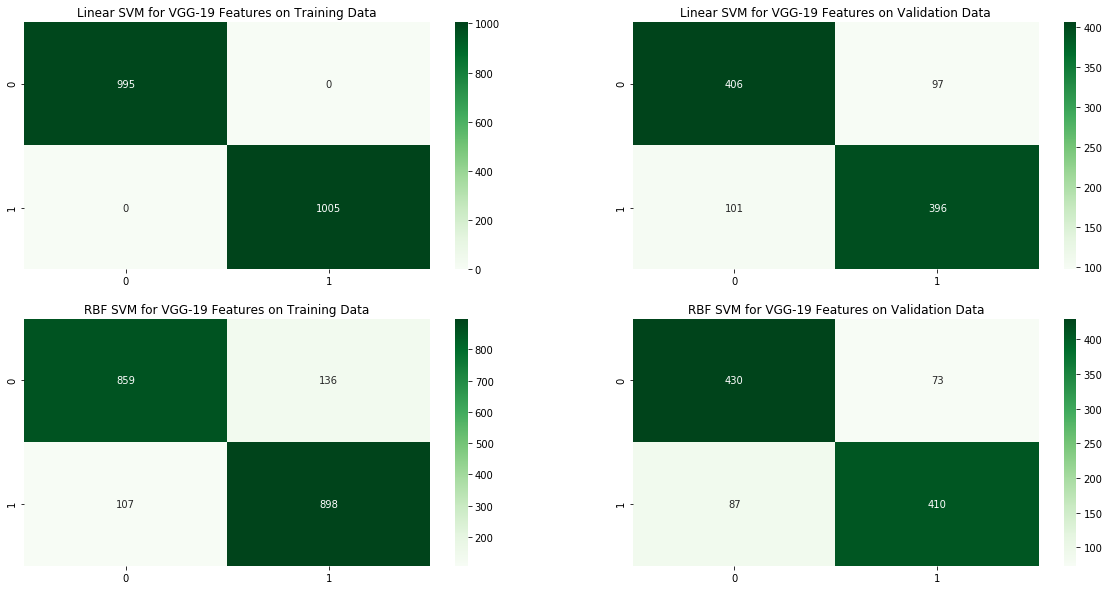

In [27]:
lin_conf_train = metrics.confusion_matrix(train_y_sample, y_hat_train_lin)
lin_conf_val = metrics.confusion_matrix(val_y_sample, y_hat_val_lin)
rbf_conf_train = metrics.confusion_matrix(train_y_sample, y_hat_train_rbf)
rbf_conf_val = metrics.confusion_matrix(val_y_sample, y_hat_val_rbf)
conf_mat_raw = [lin_conf_train, lin_conf_val, rbf_conf_train, rbf_conf_val]
conf_mat_titles = [
    "Linear SVM for VGG-19 Features on Training Data",
    "Linear SVM for VGG-19 Features on Validation Data",
    "RBF SVM for VGG-19 Features on Training Data",
    "RBF SVM for VGG-19 Features on Validation Data",
]
plt.figure(figsize = (20,10))
for i in range(4):
    plt.subplot(220 + i + 1)
    sn.heatmap(conf_mat_raw[i], annot=True, fmt='g', cmap='Greens')
    plt.title(conf_mat_titles[i])